# Previous pages (TS - ARIMA, GBR) report that there are good connections between variables so methods can be used for forecasting
# But indeed when we are talking about what is dt value going to be changed in some particular circumstances we may consider default prediction techniques

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [849]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, KFold, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error

In [2]:
# this are periods when 1,2,3,4 HEs were under operation
time_periods = [
    ("2022-09-12","2022-09-13"),
    ("2022-10-17","2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
    ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
    ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23"), ("2023-01-10","2023-01-13"), 
    ("2023-01-16","2023-01-19"), ("2023-01-24","2023-01-27"), ("2023-01-31","2023-02-03"), 
    ("2023-02-07","2023-02-09"), ("2023-02-13","2023-02-17"), ("2023-02-28","2023-03-03"), 
    ("2023-03-06","2023-03-07"), ("2023-03-09","2023-03-10"), ("2023-03-14","2023-03-17"),
    ("2023-03-27","2023-03-31"), ("2023-04-03","2023-04-07"), ("2023-04-10","2023-04-14"),
]

time_periods2 = [
    ("2021-09-06","2021-09-10"), ("2021-09-13","2021-09-17"), ("2021-09-20","2021-10-01"),
    ("2021-10-04","2021-10-08"), ("2021-10-11","2021-10-15"), ("2021-11-08","2021-11-12"),
    ("2021-11-15","2021-11-19"), ("2021-11-22","2021-11-26"), ("2021-11-29","2021-12-03"),
    ("2021-12-07","2021-12-03"), ("2021-12-13","2021-12-17"), ("2021-12-20","2021-12-24"),
    ("2022-01-18","2022-01-21"), ("2022-01-24","2022-01-26"), ("2022-02-01","2022-02-04"),
    ("2022-02-08","2022-02-11"), ("2022-02-14","2022-02-18"), ("2022-02-24","2022-02-25"),
    ("2022-03-01","2022-03-04"), ("2022-03-15","2022-03-18"), ("2022-03-21","2022-03-25"),
    ("2022-03-29","2022-04-01"), ("2022-04-12","2022-04-15"), ("2022-04-18","2022-04-22"),
    ("2022-05-02","2022-05-06"), ("2022-05-09","2022-05-13"), ("2022-05-16","2022-05-20"),
    ("2022-05-23","2022-05-27"), ("2022-06-07","2022-06-10"), ("2022-06-20","2022-06-24"),
    ("2022-06-28","2022-07-01"),
    
]

time_periods3 = [
    ("2020-10-12","2020-10-16"), ("2020-10-21","2020-10-23"), ("2020-10-28","2020-10-30"),
    ("2020-11-11","2020-11-13"), ("2020-11-16","2020-11-20"), ("2020-11-24","2020-11-27"),
    ("2020-12-03","2020-12-04"), ("2020-12-07","2020-12-11"), ("2020-12-16","2020-12-18"), 
    ("2020-12-24","2020-12-25"), ("2020-12-29","2020-12-30"), ("2021-01-12","2021-01-15"),
    ("2021-01-18","2021-01-22"), ("2021-02-01","2021-02-05"), ("2021-02-08","2021-02-12"),
    ("2021-02-15","2021-02-19"), ("2021-03-01","2021-03-05"), ("2021-03-09","2021-03-12"),
    ("2021-03-15","2021-03-19"), ("2021-03-22","2021-03-26"), ("2021-04-01","2021-04-02"),
    ("2021-04-05","2021-04-09"), ("2021-04-05","2021-04-09"), ("2021-04-12","2021-04-16"),
    ("2021-04-20","2021-04-24"), ("2021-04-26","2021-04-30"), ("2021-05-03","2021-05-07"),
    ("2021-05-11","2021-05-15"), ("2021-05-17","2021-05-21"), ("2021-05-24","2021-05-28"),
    ("2021-06-15","2021-06-18"), ("2021-06-21","2021-06-25"), ("2021-06-28","2021-07-02"),
]

In [3]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

In [4]:
time_periods_all = [*time_periods3, *time_periods2, *time_periods]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [5]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [6]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [8]:
# df = pd.read_excel("rdy_for_fe_121020_to_210423.xlsx", index_col="Timestamp")
# df_nosma = pd.read_excel("rdy_for_fe_121020_to_210423_no_sma.xlsx", index_col="Timestamp")



In [637]:
df_stats = pd.read_excel("rdy_for_stats_121020_210423.xlsx", index_col="Timestamp")

# I assume that data of winter of 2021 is not clear cuz Tair is hardly reach -5
# However usually it dropsbelow -20 -> absolutly anomaly data
## Data till april of 2021 has dropped

In [768]:
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [769]:
df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(55209, 47)

In [770]:
df_stats_gr = df_stats.groupby(pd.Grouper(freq="2h")).mean().dropna()
df_stats_gr.shape

(2490, 47)

In [709]:
df_stats_gr.columns

Index(['CTF1', 'CTF2', 'CTF3', 'P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1',
       'T2aHE2', 'T2aHE3', 'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor',
       'p21', 'p22', 'p23', 'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'QbyIP_HEs_num',
       'QbyIP_HEs_pumps_num', 'Ndis_def', 'Ndis_by_delta',
       'Ndis_by_del_HEs_num', 'dt2_by_HEs', 'ff', 'HE_TOP_mean', 'CTF_sum'],
      dtype='object')

<AxesSubplot: xlabel='QbyIP', ylabel='Count'>

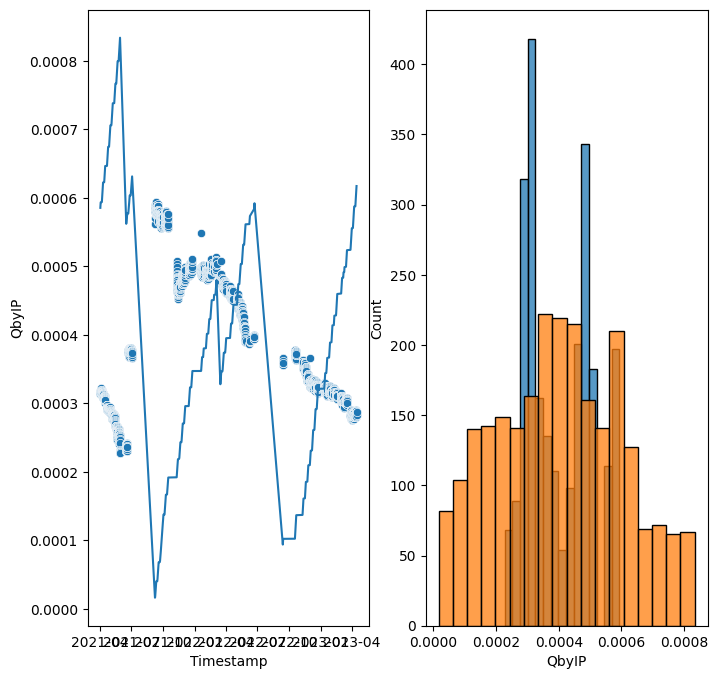

In [690]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
sns.scatterplot(df_stats_gr["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[0])
sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.histplot(df_stats_gr["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[1])
sns.histplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[1])



# Once again We may observe differend cycles which depends on whether new HE were taken to operation
## So now df going to be split by HEs in operation and their swaps

Timestamp
2021-04-01 20:00:00    10.735460
2021-04-01 22:00:00    10.674293
2021-04-02 00:00:00    10.655442
2021-04-02 02:00:00    10.623769
2021-04-02 04:00:00    10.603075
                         ...    
2021-05-28 14:00:00     7.790070
2021-05-28 16:00:00     7.739506
2021-05-28 18:00:00     7.715087
2021-05-28 20:00:00     7.705580
2021-05-28 22:00:00     7.678108
Name: QbyIP, Length: 375, dtype: float64


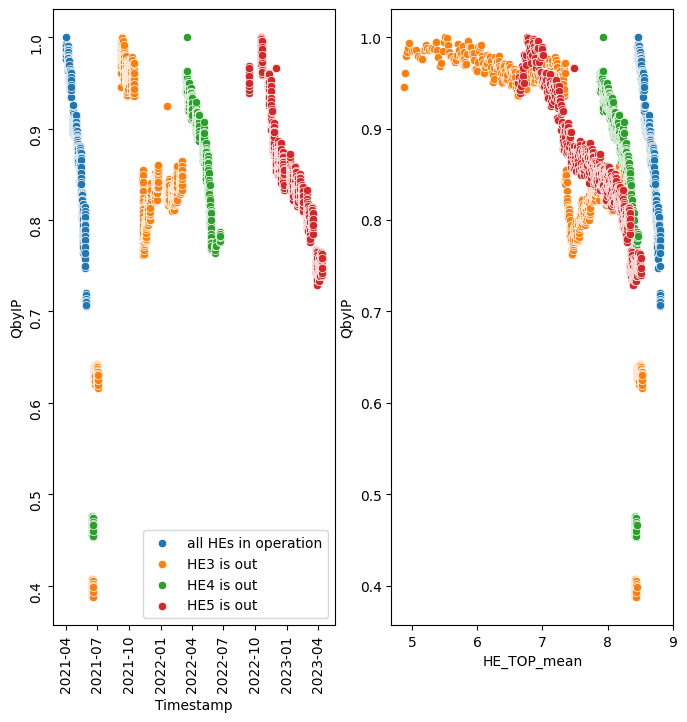

In [691]:

fig, axs = plt.subplots(1,2, figsize=(8,8))

qbyip = df_stats_gr["QbyIP"]

qbyip_all = qbyip[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
].dropna(axis=0)
qbyip3 = qbyip[df_stats_gr["HE3_status"] == 0].dropna(axis=0)
qbyip4 = qbyip[df_stats_gr["HE4_status"] == 0].dropna(axis=0)
qbyip5 = qbyip[df_stats_gr["HE5_status"] == 0].dropna(axis=0)

print(qbyip_all)

hetop_all = df_stats_gr[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
]["HE_TOP_mean"].dropna(axis=0)
hetop3 = df_stats_gr[df_stats_gr["HE3_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop4 = df_stats_gr[df_stats_gr["HE4_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop5 = df_stats_gr[df_stats_gr["HE5_status"] == 0]["HE_TOP_mean"].dropna(axis=0)


sns.scatterplot(qbyip_all / qbyip_all.max(), ax=axs[0], label="all HEs in operation")
sns.scatterplot(qbyip3 / qbyip3.max(), ax=axs[0], label="HE3 is out")
sns.scatterplot(qbyip4 / qbyip4.max(), ax=axs[0], label="HE4 is out")
sns.scatterplot(qbyip5 / qbyip5.max(), ax=axs[0], label="HE5 is out")
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].max(), ax=axs[0])

sns.scatterplot(x=np.log(hetop_all), y=qbyip_all / qbyip_all.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop3), y=qbyip3 / qbyip3.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop4), y=qbyip4 / qbyip4.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop5), y=qbyip5 / qbyip5.max(), ax=axs[1])

axs[0].tick_params(rotation=90)
# sns.scatterplot(qbyip / df_stats.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1))

# On a first look, all curves have similar trends and no matter what HEs are in operation
# However, the cycles that starts from 0 (HE_TOP_mean) have 2 different trends
# It's quite obvious that each cycle is non-stationry regarding QbyIP
# Lets take a look on dt

In [594]:
df_all = df_stats_gr.loc[qbyip_all.index, :]

In [446]:
df_all_fc119 = df_all.loc[
    fcs[0][0]: fcs[0][1],
    :
]

In [447]:
df_all = df_all.reset_index()
df_all_fc119 = df_all_fc119.reset_index()

In [17]:
df_all["pumps2"].value_counts()

234.0     325
1234.0     50
Name: pumps2, dtype: int64

<AxesSubplot: xlabel='dt1', ylabel='Count'>

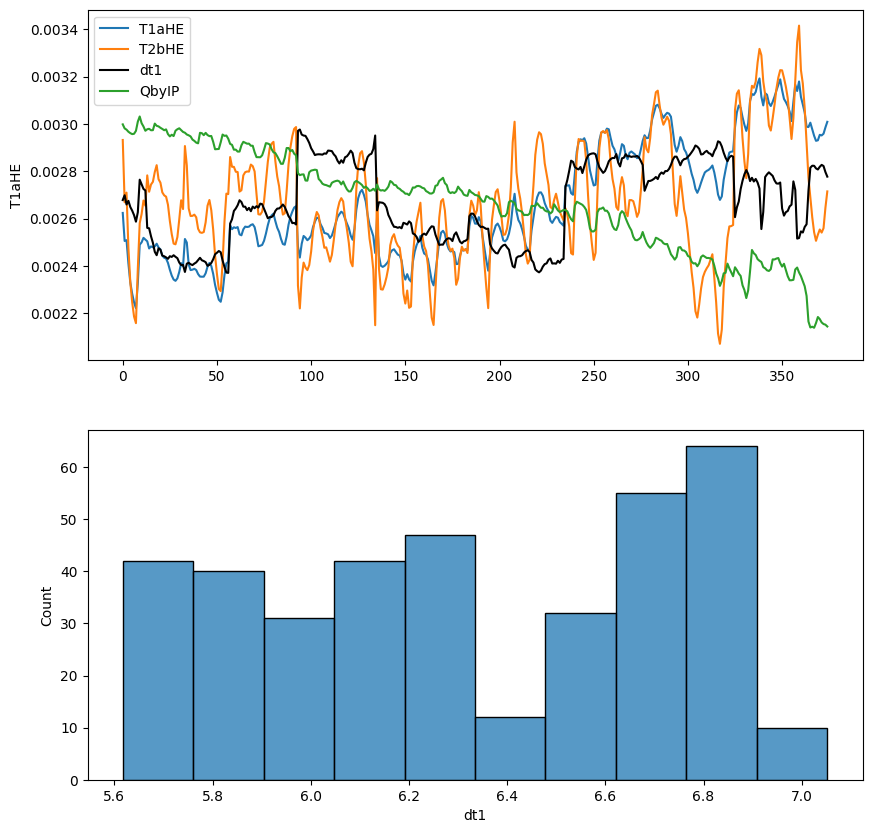

In [18]:
# dt1 distributed pretty random so there is dependent parameter --> fuel cycle

fig, axs = plt.subplots(2,1, figsize=(10,10))

sns.lineplot(df_all["T1aHE"] / df_all["T1aHE"].sum(), ax=axs[0], label="T1aHE")
sns.lineplot(df_all["T2bHE"] / df_all["T2bHE"].sum(), ax=axs[0], label="T2bHE")
sns.lineplot(df_all["dt1"] / df_all["dt1"].sum(), ax=axs[0], color="black", label="dt1")

sns.lineplot(df_all["QbyIP"] / df_all["QbyIP"].sum(), ax=axs[0], label="QbyIP")


sns.histplot(df_all["dt1"], ax=axs[1])


In [561]:
# df_all_t1ahe = df_all_fc119.loc[:, ["QbyIP", "T1bHE", "T2bHE", "T2aHE"]]
# df_all_t1ahe = df_all.loc[:, ["QbyIP", "T1bHE", "T2bHE", "T2aHE"]]


In [595]:
# df_stats_gr = df_stats_gr.reset_index().drop("Timestamp", axis=1)

In [1074]:
df_stats_t1ahe = df_stats_gr[["Q2_HEs_num", "T1bHE", "T2bHE", "T2aHE", "T1aHE", "dt2"]]

In [1075]:
df_stats_t1ahe

,Q2_HEs_num,T1bHE,T2bHE,T2aHE,T1aHE,dt2
Timestamp,,,,,,
2021-04-01 20:00:00,130.725778,48.583810,23.855201,30.445497,42.237482,6.590296
2021-04-01 22:00:00,130.263167,46.725073,21.713469,28.329850,40.330685,6.616381
2021-04-02 00:00:00,129.694714,46.685364,22.046316,28.576093,40.383519,6.529777
2021-04-02 02:00:00,129.600417,45.138733,20.142970,26.737512,38.800581,6.594541
2021-04-02 04:00:00,129.626125,43.780384,18.980437,25.488457,37.503260,6.508020
...,...,...,...,...,...,...
2023-04-14 00:00:00,163.047448,47.933606,24.074996,30.105447,41.543079,6.030451
2023-04-14 02:00:00,162.083958,46.151325,22.686828,28.547813,39.856837,5.860985
2023-04-14 04:00:00,162.915885,47.487143,24.402059,30.182131,41.232871,5.780072


In [1076]:
df_stats_t1ahe["dt_circuits_coef_delta"] = df_stats_t1ahe["T2aHE"] - df_stats_t1ahe["T2bHE"]

/tmp/ipykernel_8206/952842295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_t1ahe["dt_circuits_coef_delta"] = df_stats_t1ahe["T2aHE"] - df_stats_t1ahe["T2bHE"]


In [1077]:
df_stats_t1ahe_noresampe = df_stats_t1ahe.copy()

In [1078]:
df_stats_t1ahe_noresampe = df_stats_t1ahe_noresampe.reset_index().drop("Timestamp", axis=1)

In [1079]:
df_stats_t1ahe = df_stats_t1ahe.sample(frac=1).reset_index().drop("Timestamp", axis=1)

In [1080]:
df_stats_t1ahe

,Q2_HEs_num,T1bHE,T2bHE,T2aHE,T1aHE,dt2,dt_circuits_coef_delta
0,164.660987,47.705074,24.687353,30.822398,41.103443,6.135045,6.135045
1,159.782500,45.369158,21.898190,28.055878,38.848215,6.157689,6.157689
2,186.994323,48.810762,27.878383,33.740902,42.384190,5.862519,5.862519
3,173.721823,49.370082,26.566288,32.582862,42.679809,6.016573,6.016573
4,219.221458,42.810400,24.156052,29.189533,36.879569,5.033480,5.033480
...,...,...,...,...,...,...,...
2485,169.906354,45.735487,22.528613,28.601520,39.110450,6.072907,6.072907
2486,208.438261,57.325570,23.191348,28.903728,51.031493,5.712380,5.712380
2487,225.066042,46.000898,27.264864,32.499165,39.762200,5.234301,5.234301
2488,168.680365,47.857906,24.864463,30.881076,41.269155,6.016613,6.016613


Index(['Q2_HEs_num', 'T1bHE', 'T2bHE', 'T2aHE', 'T1aHE', 'dt2',
       'dt_circuits_coef_delta'],
      dtype='object')


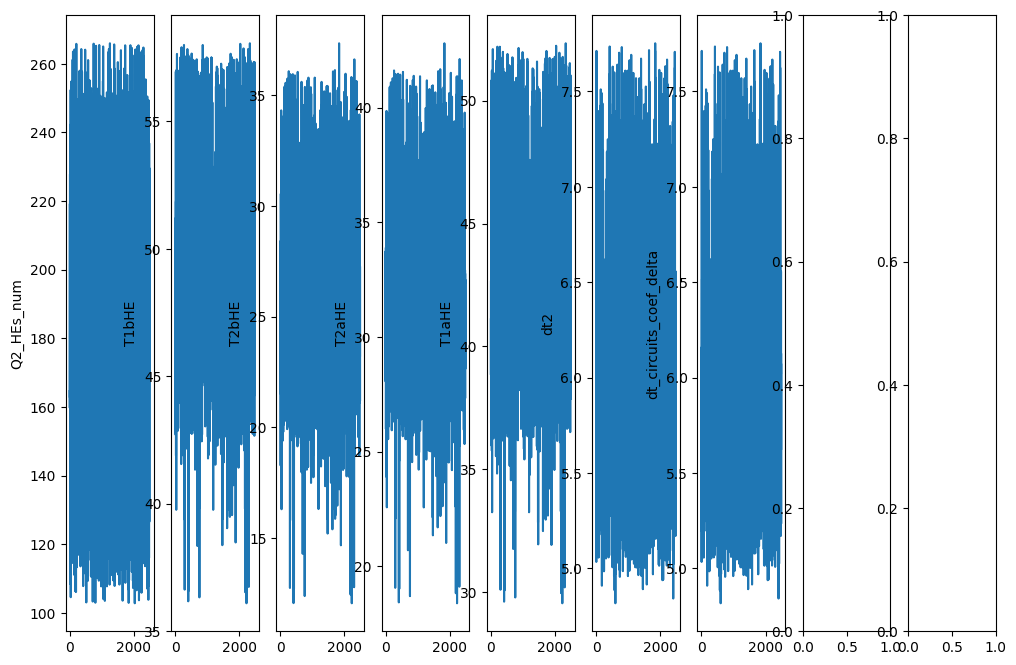

In [1081]:
fig, axs = plt.subplots(1,len(cols), figsize=(12,8))
cols = df_stats_t1ahe.columns
print(cols)
for i in range(len(cols)):
    sns.lineplot(df_stats_t1ahe[cols[i]], ax=axs[i])

Index(['Q2_HEs_num', 'T1bHE', 'T2bHE', 'T2aHE', 'T1aHE', 'dt2',
       'dt_circuits_coef_delta'],
      dtype='object')


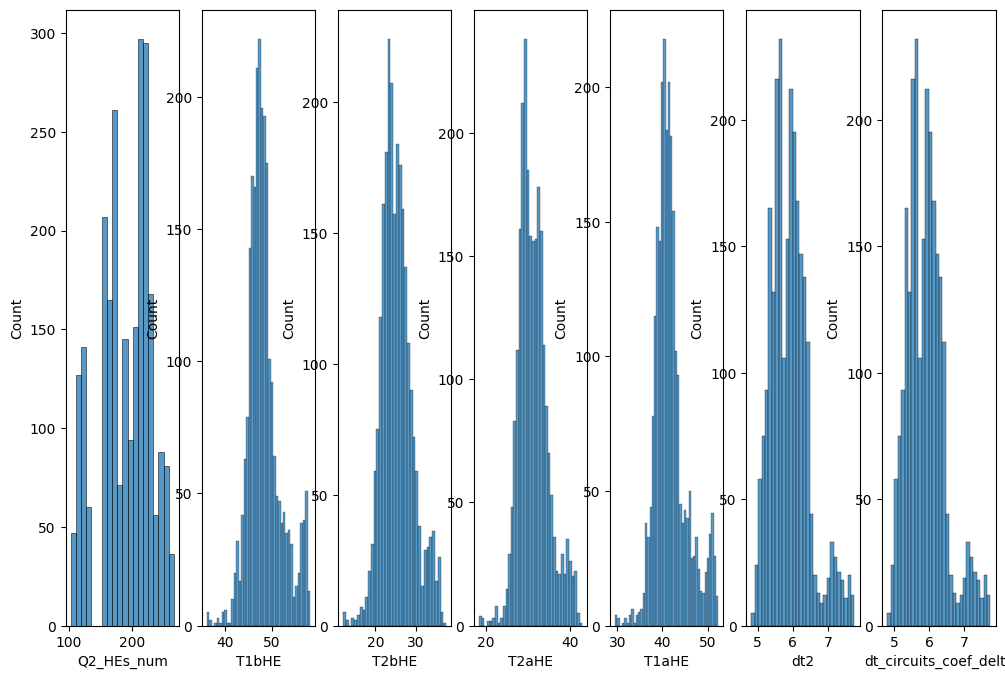

In [1082]:
fig, axs = plt.subplots(1,len(cols), figsize=(12,8))
cols = df_stats_t1ahe.columns
print(cols)
for i in range(len(cols)):
    sns.histplot(df_stats_t1ahe[cols[i]], ax=axs[i])

Index(['Q2_HEs_num', 'T1bHE', 'T2bHE', 'T2aHE', 'T1aHE', 'dt2',
       'dt_circuits_coef_delta'],
      dtype='object')


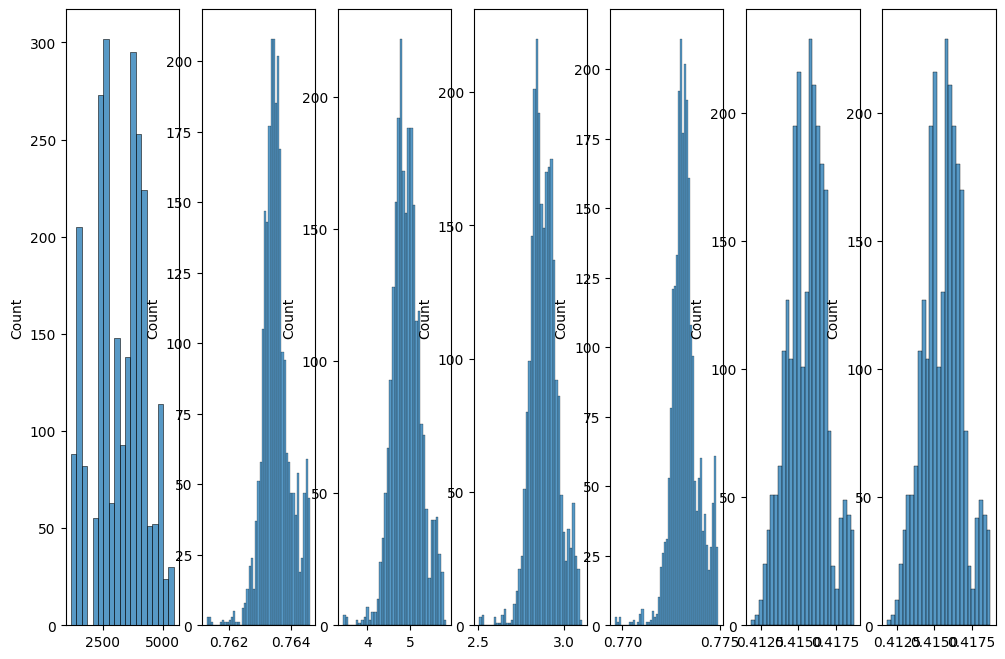

In [1083]:
fig, axs = plt.subplots(1,len(cols), figsize=(12,8))
cols = df_stats_t1ahe.columns
print(cols)
for i in range(len(cols)):
    bx, *_ = scipy.stats.boxcox(
            df_stats_t1ahe[cols[i]]
        )
    sns.histplot(
        bx,
        ax=axs[i]
    )

In [1084]:
# filter noise by Z-score
# fe = FeatureEngineering(df_stats_t1ahe)

In [1085]:
# for i in df_all_diff.columns:
#     fe.filter_by_zscore(i)

In [1086]:
# df_all_diff.loc[:, [*df_all_diff.columns, "dt_circuits_coef_delta"]] = fe.df.loc[:, [*df_all_diff.columns, "dt_circuits_coef_delta"]]

In [1087]:
df_stats_t1ahe_t1bHE_np = NonParametric(df_stats_t1ahe["T1bHE"])

In [1088]:
df_stats_t1ahe_t1bHE_np.run_tests()

Made <KRUSKAL> test:
 Fail to reject H0 hypothesis:
 Verdict: Population medians are equal
pvalue of test is 0.683

Made <WILCOXON> test:
 Reject H0 hypothesis -> H1 hypothesis:
 Verdict: Medians of two samples are different
pvalue of test is 0.000

Made <MANNWHITNEYU> test:
 Fail to reject H0 hypothesis:
 Verdict: Two populations are equal
pvalue of test is 0.683

Made <NORMALTEST> test:
 Reject H0 hypothesis -> H1 hypothesis:
 Verdict: The data does not come from a specified distribution
pvalue of test is 0.000

Made <SHAPIRO> test:
 Reject H0 hypothesis -> H1 hypothesis:
 Verdict: The data does not come from a specified distribution
pvalue of test is 0.000

Made <ANDERSON> test:
 Reject H0 hypothesis -> H1 hypothesis:
 Verdict: The data does not come from a specified distribution
pvalue of test is 0.000



In [1089]:
X = df_stats_t1ahe.drop(["T1aHE", "T2aHE"], axis=1)
y1 = df_stats_t1ahe["T1aHE"]
y2 = df_stats_t1ahe["T2aHE"]

In [1090]:
X.shape, y1.shape

((2490, 5), (2490,))

In [1091]:
gbr = GradientBoostingRegressor()

In [1092]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [1093]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.3)

In [1094]:
pl = make_pipeline(
    ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), X.columns)
        ],
        remainder="passthrough"
    ),
    GradientBoostingRegressor()
).set_output(transform="pandas")

In [1095]:
gbr_pl1 = pl.fit(X, y1)

0.09066359012406312


(array([0.01233612, 0.98114231, 0.00315935, 0.00176676, 0.00159546]),
 Index(['Q2_HEs_num', 'T1bHE', 'T2bHE', 'dt2', 'dt_circuits_coef_delta'], dtype='object'))

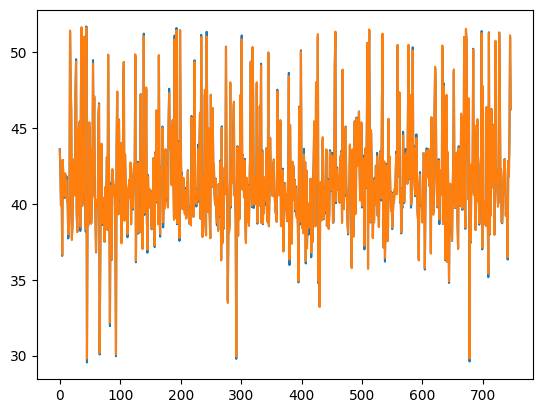

In [1096]:
# fig, axs = plt.subplots(1,3, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
gbr.fit(
    X_train,
    y_train
)
sns.lineplot(
    y_test.to_numpy()
)
sns.lineplot(
    gbr_pl1.predict(
        X_test
    )
)
print(mean_absolute_error(
    y_test,
    gbr_pl1.predict(
        X_test
    )
))
gbr.feature_importances_, X.columns

In [1097]:
X_noresamle = df_stats_t1ahe_noresampe.drop(["T1aHE", "T2aHE"], axis=1)
y1_noresample = df_stats_t1ahe_noresampe["T1aHE"]
y2_noresample = df_stats_t1ahe_noresampe["T2aHE"]


In [1098]:
# try Kfolds
folds = list(KFold(n_splits=3).split(X_noresamle, y1_noresample))

1.5877338614261012
0.2873738350157363
0.38696218805833177


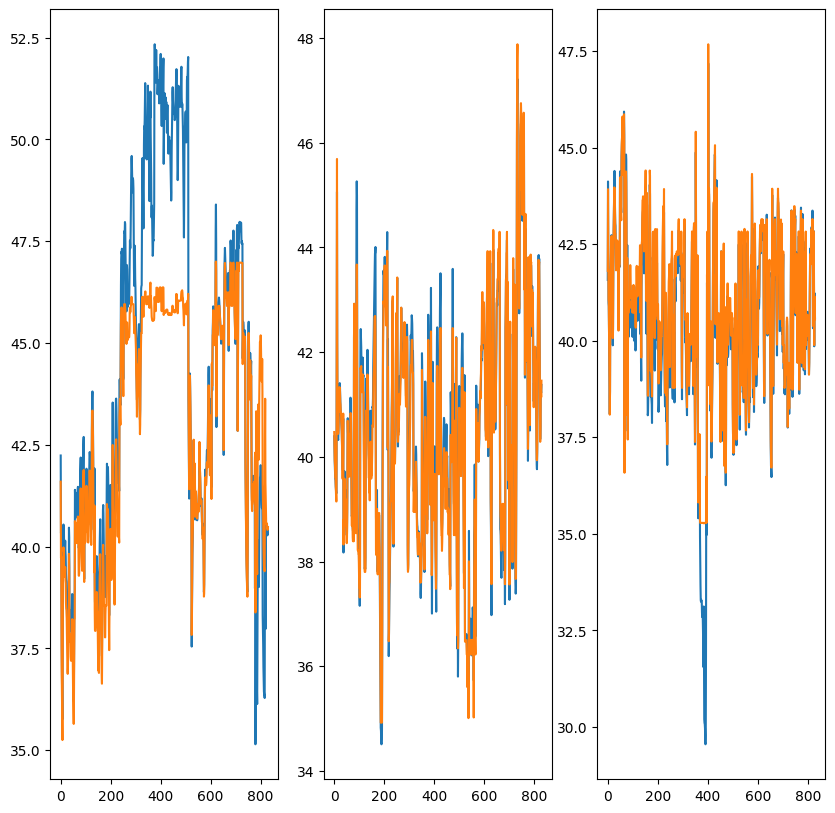

In [1099]:
fig, axs = plt.subplots(1, len(folds), figsize=(10,10))
for n, (tr, te) in enumerate(folds):
    gbr_pl2 = pl.fit(
        X_noresamle.loc[tr, :],
        y1_noresample.loc[tr]
    )
    
    sns.lineplot(
        y1_noresample.to_numpy()[te],
        ax=axs[n]
    )
    sns.lineplot(
        gbr_pl2.predict(
            X_noresamle.loc[te, :]
        ),
        ax=axs[n]
    )
    print(mean_absolute_error(
        y1_noresample.to_numpy()[te],
        gbr_pl2.predict(
            X_noresamle.loc[te, :]
        )
    ))

[('2021-03-09', '2021-04-12'),
 ('2021-04-12', '2021-05-11'),
 ('2021-05-11', '2021-09-20')]

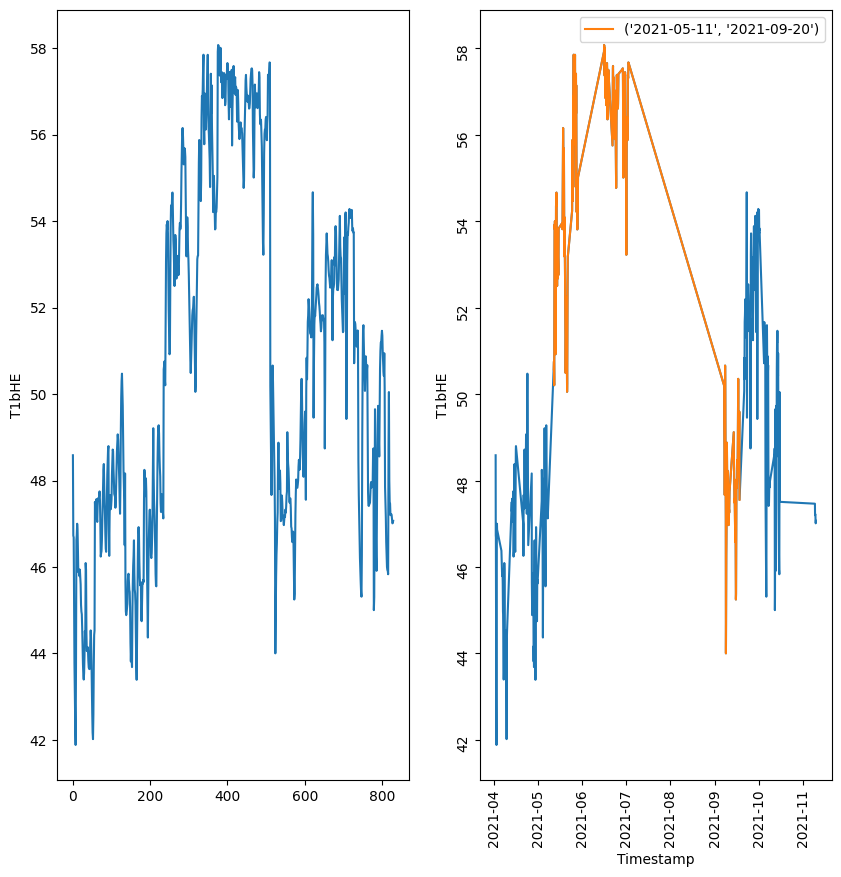

In [1116]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))

sns.lineplot(X_noresamle.loc[folds[0][1], "T1bHE"], ax=axs[0])

sns.lineplot(
    df_stats_gr.iloc[folds[0][1]]["T1bHE"], 
    ax=axs[1]
)
sns.lineplot(
    df_stats_gr.iloc[folds[0][1]].loc[fcs[2][0]: fcs[2][1],"T1bHE"], 
    ax=axs[1],
    label=fcs[2]
)
axs[1].tick_params(rotation=90)
fcs

# As follows from results above the prediction feature strongly depends on T1bHE
# But as we can see from data above - for different fuel cycles machine learning loses why data may be changed. So there are no features that may describe the behavior of reactor core